In [ ]:
!apt install swig
!pip install orthnet

In [1]:

import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

from orthnet import Legendre, Chebyshev

%matplotlib inline

GPU_MODE = True

In [2]:
if GPU_MODE:
  cuda0 = torch.device('cuda:0')
  print(torch.cuda.device_count(), torch.cuda.get_device_name(0))
  torch.cuda.init()

1 NVIDIA GeForce GTX 1070


In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [4]:
class LegendreActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 , i):
            if (i + j) % 2 == 1:
              self.D[i, j] = 2 * (j + 1) - 1
    
    def forward(self, X):              
      data = Legendre(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T


class LegendreBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Legendre = LegendreActivation(self.degree)

    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Legendre(X)
      return data

class ChebyshevActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 ,i):
            if (i+j) % 2 == 1:
              self.D[i, j] = 2 * i
              if j == 0:
                self.D[i, j] = self.D[i, j]/2.0
    def forward(self, X):              
      data = Chebyshev(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T

class ChebyshevBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Chebyshev = ChebyshevActivation(self.degree)


    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Chebyshev(X)
      
      return data

In [5]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

In [6]:
domain = [0, 6]
n_discretization = 3000 * domain[1] - domain[0]

In [7]:
n_input = 1
n_output = 1
eps = 1e-10

In [8]:
if GPU_MODE:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double, device=cuda0).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()
else:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()

In [9]:
mlp = nn.Sequential(  
  LegendreBlock(n_input, 16),
  ChebyshevBlock(16, 5),
  nn.Linear(5, n_output)
).double()


pytorch_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
pytorch_total_params

25

In [10]:
if GPU_MODE:
  mlp.to('cuda:0')

In [11]:
def get_loss(x, ret_res=False):
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Generall Falkner-Skan Eq.: 
    f''' + α ff'' + β(1 - (f')^2) = 0 ,
    f(0) = f'(0) = 0, f'(∞) = 1
  
  Hiemenz Flow = (α, β) = (1, 1)  
  """
  alpha = 1
  beta = 1

  residual = (y_xxx) + (alpha * y_xx * y) + (beta * (1 - y_x**2))


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [12]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [13]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 500
epoch_LBFGS = 10000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().cpu().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().cpu().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00016.2578325111
Step: 002 loss = 00004.4278931917
Step: 004 loss = 00002.4382912046
Step: 006 loss = 00002.2211017163
Step: 008 loss = 00002.1239457226
Step: 010 loss = 00002.0397459612
Step: 012 loss = 00001.9920577516
Step: 014 loss = 00001.9823986889
Step: 016 loss = 00001.9987444516
Step: 018 loss = 00002.0263781710
Step: 020 loss = 00002.0530473841
Step: 022 loss = 00002.0709308278
Step: 024 loss = 00002.0768219173
Step: 026 loss = 00002.0713178167
Step: 028 loss = 00002.0574796229
Step: 030 loss = 00002.0393200702
Step: 032 loss = 00002.0205198197
Step: 034 loss = 00002.0036689275
Step: 036 loss = 00001.9900610072
Step: 038 loss = 00001.9798659347
Step: 040 loss = 00001.9724763483
Step: 042 loss = 00001.9668876773
Step: 044 loss = 00001.9620371875
Step: 046 loss = 00001.9570655679
Step: 048 loss = 00001.9514822186
Step: 050 loss = 00001.9452216181
Step: 052 loss = 00001.9385847911
Step: 054 loss = 00001.9320805246
Step: 056 loss = 00001.9262145820
Step: 058 loss

In [14]:
# calculate f''(0)
# # make zero Tensor from x Tensor
zerox = x.clone()
zerox[0][0] = 0
f_xx_0 = d2y_dx2(mlp(zerox), zerox)[0]
print("f''(0) = {}".format(f_xx_0[0]))


#  Standard = 1.232589

f''(0) = 1.2325484149952608


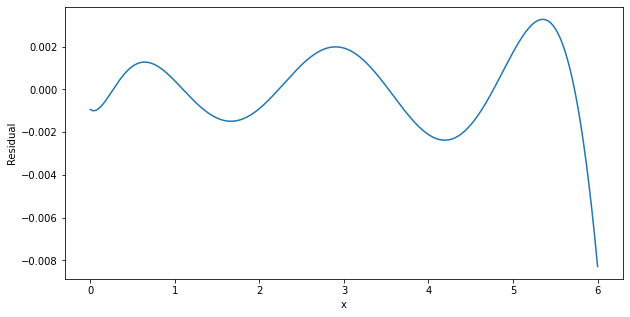

In [15]:
mlp.to('cpu')
plt.figure(figsize=(10, 5))
domain = x.cpu().detach().numpy().flatten()

res= get_loss(x.cpu(), ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

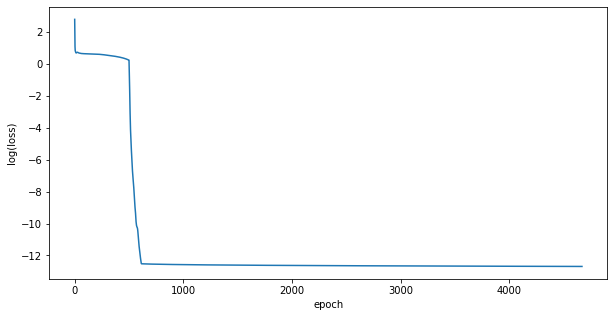

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')